<a href="https://colab.research.google.com/github/christophercallaghan2022/MSDS422/blob/main/Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 

(1) Begin by fitting a random forest classifier using the full set of 784 explanatory variables and the model training set (train.csv). Record the time it takes to fit the model and then evaluate the model on the test.csv data by submitting to Kaggle.com. Provide your Kaggle.com score and user ID.

(2) Execute principal components analysis (PCA) on the combined training and test set data together, generating principal components that represent 95 percent of the variability in the explanatory variables. The number of principal components in the solution should be substantially fewer than the 784 explanatory variables. Record the time it takes to identify the principal components.

(3) Using the identified principal components from step (2), use the train.csv to build another random forest classifier. Record the time it takes to fit the model and to evaluate the model on the test.csv data by submitting to Kaggle.com. Provide your Kaggle.com score and user ID.

(4) Submit both the RF Classifier and the PCA RF Classifier to Kaggle.com, and report both scores along with your user name.  I MUST have your user name to verify submission status.

(5) The experiment we have proposed has a MAJOR design flaw. Identify the flaw. Fix it. Rerun the experiment in a way that is consistent with a training-and-test regimen, and submit this to Kaggle.com. Provide your Kaggle.com score and user ID.

(6)  Use k-means clustering to group MNIST observations into 1 of 10 categories and then assign labels.

#Data Dictionary




* Label = Numerical value
* Pixel 0-783 = pixel value indicating lightness or darkness of that pixel between 0 and 255



# Data Preparation

In [2]:
#S2 Mount Google Drive to Colab Enviorment
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
#S3 Establish working directory
import os # Operation System
os.getcwd()
%cd /content/gdrive/My Drive/MSDS_422/Assignment_5
!pwd
!ls
print('Working Directory')
print(os.getcwd())

/content/gdrive/My Drive/MSDS_422/Assignment_5
/content/gdrive/My Drive/MSDS_422/Assignment_5
test.csv  train.csv
Working Directory
/content/gdrive/My Drive/MSDS_422/Assignment_5


In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# ignore warnings
from sklearn.exceptions import DataConversionWarning
import warnings

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore', category=DataConversionWarning)
warnings.simplefilter("ignore", category=PendingDeprecationWarning)
warnings.simplefilter('ignore', category=DeprecationWarning)

# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# Preview the train data
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
# Describe the data 
train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.00000,42000.000000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,...,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00300,0.011190,0.005143,0.000214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000381,0.001310,0.010548,0.027262,0.050905,0.066405,0.129571,...,3.772524,2.748905,1.796452,1.089905,0.563190,0.239571,0.093524,0.024833,0.000857,0.001405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006143,0.035833,0.082357,0.114905,0.178714,0.301452,0.413643,0.513667,0.558833,0.677857,0.60281,0.489238,0.340214,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.56812,1.626927,1.053972,0.043916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078072,0.232634,1.131661,2.310396,3.121847,3.259128,4.992894,...,26.957829,22.879248,18.595109,14.434439,10.517823,6.469315,3.976306,1.846016,0.139556,0.287891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.949803,2.350859,3.934280,4.543583,5.856772,7.219742,8.928286,10.004069,10.129595,11.254931,10.69603,9.480066,7.950251,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [5]:
# Preview test data
# Note: test data does not have the label column
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


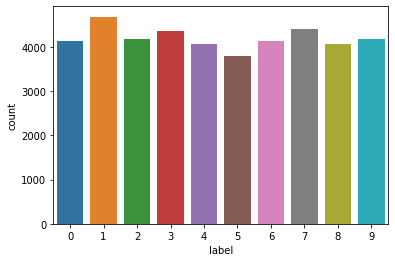

In [6]:
# Explore distribution of labels present
sns.countplot(x='label', data=train);

In [7]:
# Group the train and test data into labels and features
y_train = train['label']
X_train = train.drop(['label'], axis=1)

X_test = test
X_train.shape, y_train.shape, X_test.shape

((42000, 784), (42000,), (28000, 784))

In [8]:
# Normalize the data since we know the max pixel value is 255 we can divide by that value so all values will be between 0-1
X_train = X_train / 255.0
X_test = X_test / 255.0

In [9]:
# Take a sample to reshape (28 x 28) and plot out example data
sample_size = train.shape[0]

train_x = np.asarray(train.iloc[:sample_size,1:]).reshape([sample_size,28,28,1])
train_y = np.asarray(train.iloc[:sample_size,0]).reshape([sample_size,1]) 

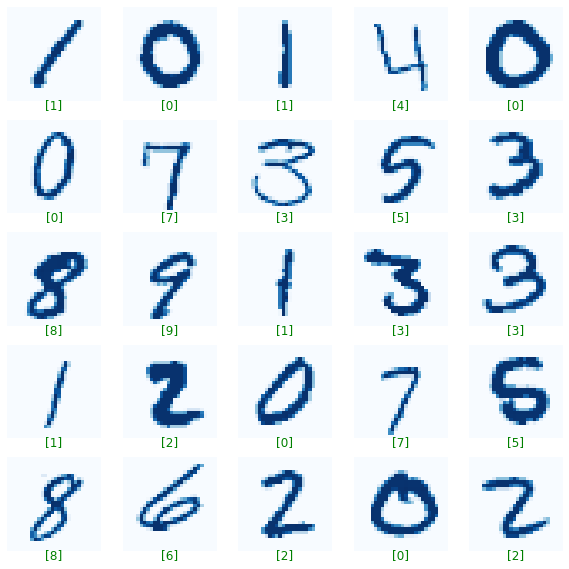

In [10]:
rows = 5 
cols = 5 

f = plt.figure(figsize=(2*cols,2*rows))

for i in range(rows*cols): 
    f.add_subplot(rows,cols,i+1)
    plt.imshow(train_x[i].reshape([28,28]),cmap="Blues") 
    plt.axis("off")
    plt.title(str(train_y[i]), y=-0.15,color="green")

# 1. Random Classifier

In [11]:
#Split train data to run through Random Classifier
from sklearn.model_selection import train_test_split
X_train_RC, X_test_RC, y_train_RC, y_test_RC = train_test_split(X_train, y_train, test_size = 0.2, random_state= 42)

In [12]:
%%time

import time

# create an empty list to store time results
rf_time = []

#fit a Random Forest Classifier onto the training set
from sklearn.ensemble import RandomForestClassifier

start_time = time.clock()
rf_clf = RandomForestClassifier(max_features = 'sqrt', n_estimators=10, bootstrap=True, random_state=RANDOM_SEED)
rf_clf.fit(X_train_RC,y_train_RC)
end_time = time.clock()

runtime = end_time - start_time

#append the results to the list
rf_time.append(runtime)

Success!
CPU times: user 2.66 s, sys: 102 ms, total: 2.76 s
Wall time: 2.77 s


In [13]:
# call the predict method onto the holdout test set
y_pred_RC = rf_clf.predict(X_test_RC)

In [14]:
from sklearn.metrics import classification_report

print("Random Forest Classification Report: \n{}".format(classification_report(y_test_RC, y_pred_RC)))

Random Forest Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       816
           1       0.97      0.99      0.98       909
           2       0.92      0.94      0.93       846
           3       0.90      0.91      0.91       937
           4       0.93      0.95      0.94       839
           5       0.91      0.92      0.91       702
           6       0.95      0.96      0.95       785
           7       0.95      0.93      0.94       893
           8       0.93      0.89      0.91       835
           9       0.93      0.91      0.92       838

    accuracy                           0.94      8400
   macro avg       0.94      0.94      0.94      8400
weighted avg       0.94      0.94      0.94      8400



In [15]:
# interested in just seeing performance using the F1 score
from sklearn.metrics import f1_score

scores = []

rf_f1score = f1_score(y_test_RC, y_pred_RC, average='weighted')
scores.append(rf_f1score)

print("F1 Score: {:4f}".format(rf_f1score))

F1 Score: 0.9377299986329973


In [16]:
# Apply classifier to predict labels in test set
y_pred = rf_clf.predict(X_test)

In [17]:
test["label"] = y_pred

test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,label
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


In [18]:
cols = test.columns.tolist()

cols = cols[-1:]+cols[:-1]
test = test[cols]

test.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##Output test file to submit to Kaggle

In [19]:
test1_kaggle = test[["label"]]

In [20]:
test1_kaggle.describe()

,label
count,28000.000000
mean,4.392429
std,2.890170
min,0.000000
25%,2.000000
50%,4.000000
75%,7.000000
max,9.000000


In [41]:
test1_kaggle.index.names = ['ImageId']
test1_kaggle.index = test1_kaggle.index + 1

test1_kaggle.head()

,label
ImageId,
1,2
2,0
3,9
4,9
5,3


In [42]:
test1_kaggle.to_csv('Callaghan_Step1_Classifier_test.csv')

# 2. PCA

##Combine the two files to get the full data set

In [22]:
full_df = pd.concat([train,test],axis=0)

X_full = full_df.drop(['label'], axis=1)
y_full = full_df['label'].astype('int64')

full_df.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,70000.000000,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.000000,70000.000000,70000.000000,70000.000000,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,...,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.0,70000.0,70000.0,70000.0
mean,4.430957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001800,0.006714,0.003086,0.000129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000229,0.001329,0.011329,0.023071,0.043229,0.062243,0.117929,...,3.572529,2.597929,1.659614,0.992457,0.541814,0.245643,0.080957,0.021000,0.000829,0.000843,0.0,0.0,0.0,0.0,0.0,0.0,0.002171,0.013357,0.036000,0.082671,0.122586,0.187657,0.310871,0.394871,0.495457,0.571071,0.669500,0.589571,0.479229,0.333600,0.197414,0.099543,0.046629,0.016614,0.012957,0.001714,0.0,0.0,0.0,0.0
std,2.888857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.440064,1.260218,0.816403,0.034017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.060474,0.230432,1.322745,2.029539,2.951033,3.242019,4.820413,...,26.274268,22.238669,17.840756,13.744477,10.299782,6.699808,3.631055,1.638692,0.136380,0.222999,0.0,0.0,0.0,0.0,0.0,0.0,0.405072,1.593527,2.409111,3.872385,4.709048,6.022443,7.421689,8.660856,9.605280,10.274678,11.236708,10.501991,9.448936,7.921717,5.991206,4.256304,2.783732,1.561822,1.553796,0.320889,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [23]:
full_df.dtypes

label       int64
pixel0      int64
pixel1      int64
pixel2      int64
pixel3      int64
            ...  
pixel779    int64
pixel780    int64
pixel781    int64
pixel782    int64
pixel783    int64
Length: 785, dtype: object

In [24]:
#Normalize by dividing pixel values by 255
X_full = X_full / 255

## Run full dataset through PCA

In [25]:
%%time

# create an empty list to store time results
pca_time = []

# use PCA on all 70,000 observations
from sklearn.decomposition import PCA

start_time = time.clock()
pca = PCA(n_components=0.95, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X_full)
end_time = time.clock()

runtime = end_time - start_time

#append the results to the list
pca_time.append(runtime)

print("Success!")

Success!
CPU times: user 25.6 s, sys: 1.54 s, total: 27.1 s
Wall time: 14.3 s


In [26]:
# show the reduction in features (784 to 154)
print(X_train.shape)
print(X_pca.shape)

(42000, 784)
(70000, 154)


Text(0.5, 1.0, 'PCA - Explained Variance Ratio Cumulative Distribution')

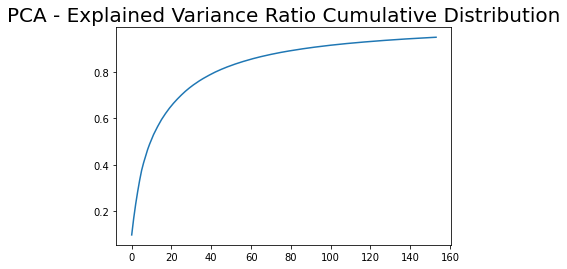

In [27]:
# PCA - Explained Variance Ratio Cumulative Distribution
var = pca.explained_variance_ratio_.cumsum()
plt.plot(var)
plt.title("PCA - Explained Variance Ratio Cumulative Distribution", fontsize=20)

# 3. Random classifier using reduced feature count

In [66]:
# set up PCA training and test sets for features
X_train_pca = X_pca[:42000]
X_test_pca = X_pca[42000:]

X_test_pca.shape

(28000, 154)

In [67]:
%%time

# create an empty list to store time results
rf_pca_time = []

#fit another Random Forest Classifier onto the the training set with the
# identified principal components
start_time = time.clock()
rf_clf.fit(X_train_pca,y_train)
end_time = time.clock()

runtime = end_time - start_time

#append the results to the list
rf_pca_time.append(runtime)

print("Success!")

Success!
CPU times: user 7.99 s, sys: 5.44 ms, total: 8 s
Wall time: 8.03 s


In [68]:
# call the predict method onto the holdout test set
y_pred_pca = rf_clf.predict(X_test_pca)
y_pred_pca.shape

(28000,)

##Output test file to submit to Kaggle

In [70]:
test["label"] = y_pred_pca

test.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
ImageId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [71]:
test2_kaggle = test[["label"]]

test2_kaggle.index.names = ['ImageId']
test2_kaggle.index = test2_kaggle.index + 1

test2_kaggle.head()

,label
ImageId,
1,2
2,0
3,9
4,2
5,2


In [72]:
test2_kaggle.to_csv('Callaghan_Step2_Classifier_test.csv')

# 4. Kaggle Results


User ID: ccallag11

*   Score 1 (Random Classifier): 0.93771
*   Score 2 (Random Classifier with PCA): 0.8811

# 5. Identify issue, fix, and rerun

The issue is that we used PCA on the full set vs. running PCA on the train and test sets individually

In [75]:
%%time

# create an empty list to store time results
pca1_time = []

#use pca on only training
from sklearn.decomposition import PCA

start_time = time.clock()
pca = PCA(n_components = 154,random_state=RANDOM_SEED)
X_train_pca1 = pca.fit_transform(X_train)
X_test_pca1 = pca.transform(X_test)
end_time = time.clock()

runtime = end_time - start_time

#append the results to the list
pca1_time.append(runtime)

print("Success!")

Success!
CPU times: user 12.8 s, sys: 2.9 s, total: 15.7 s
Wall time: 8.86 s


In [76]:
X_test_pca1.shape

(28000, 154)

In [77]:
%%time

# create an empty list to store time results
rf_pca1_time = []

#fit another Random Forest Classifier onto the the training set with the
# identified principal components
start_time = time.clock()
rf_clf.fit(X_train_pca1,y_train)
end_time = time.clock()

runtime = end_time - start_time

#append the results to the list
rf_pca1_time.append(runtime)

print("Success!")

Success!
CPU times: user 8.16 s, sys: 10.6 ms, total: 8.17 s
Wall time: 8.2 s


In [84]:
# call the predict method onto the holdout test set

y_pred_pca1 = rf_clf.predict(X_test_pca1)

## Output test file to submit to Kaggle

In [79]:
test["label"] = y_pred_pca1

test.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
ImageId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [81]:
test3_kaggle = test[["label"]]

test3_kaggle.index.names = ['ImageId']
test3_kaggle.index = test3_kaggle.index + 1

test3_kaggle.head()

,label
ImageId,
1,2
2,0
3,9
4,7
5,2


In [82]:
test3_kaggle.to_csv('Callaghan_Step3_Classifier_test.csv')

User ID: ccallag11

*   Score 1 (Random Classifier): 0.93771
*   Score 2 (Random Classifier with PCA): 0.8811
*   Score 3 (RC with fixed PCA): 0.88489

# 6. K-means